In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
base_dir = 'basedata/'
yes_dir = os.path.join(base_dir, 'yes')
no_dir = os.path.join(base_dir, 'no')

print('total have tumor images:', len(os.listdir(yes_dir)))
print('total no tumor images:', len(os.listdir(no_dir)))

total have tumor images: 90
total no tumor images: 58


In [3]:
yes_files = os.listdir(yes_dir)
print(yes_files[:10])

no_files = os.listdir(no_dir)
print(no_files[:10])

['img-00001-00001.jpg', 'img-00001-00002.jpg', 'img-00001-00003.jpg', 'img-00001-00004.jpg', 'img-00001-00005.jpg', 'img-00001-00006.jpg', 'img-00001-00007.jpg', 'img-00001-00008.jpg', 'img-00001-00009.jpg', 'img-00001-00010.jpg']
['img-00001-00091.jpg', 'img-00001-00092.jpg', 'img-00001-00093.jpg', 'img-00001-00094.jpg', 'img-00001-00095.jpg', 'img-00001-00096.jpg', 'img-00001-00097.jpg', 'img-00001-00098.jpg', 'img-00001-00099.jpg', 'img-00001-00100.jpg']


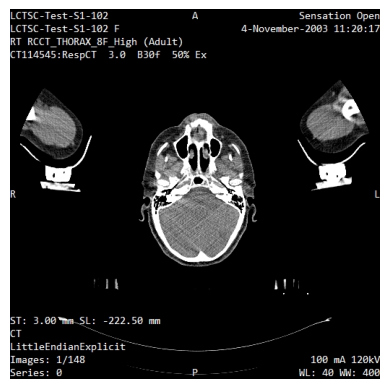

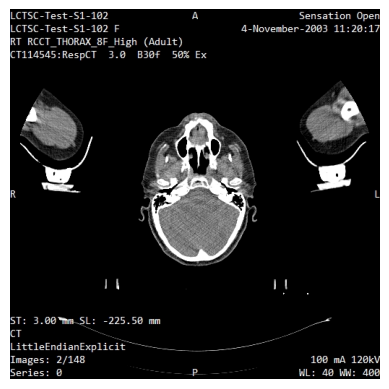

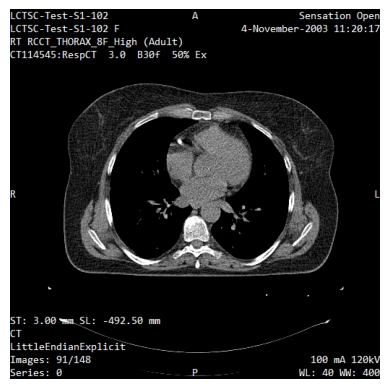

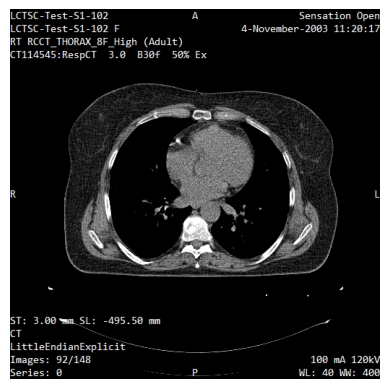

In [4]:
%matplotlib inline

pic_index = 2

next_yes = [os.path.join(yes_dir, fname) 
                for fname in yes_files[pic_index-2:pic_index]]
next_no = [os.path.join(no_dir, fname) 
                for fname in no_files[pic_index-2:pic_index]]


for i, img_path in enumerate(next_yes+next_no):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [5]:
dataset=[]
target=[]
for image_name in yes_files:
    image=cv2.imread(yes_dir + '/' +image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(1)
    
for image_name in no_files:
    image=cv2.imread(no_dir + '/' + image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(0)

In [6]:
data = np.array(dataset)
target = np.array(target)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,target,test_size=0.05,random_state=True) 

In [8]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

def preprocess_data(X):
    X_p = tf.keras.applications.resnet50.preprocess_input(X)
    return X_p

In [9]:

def resnet_model(X, augmentation=data_augmenter()):
    '''
    classification model
    '''
    
#     input_shape = X[0].shape
    
    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)
    
    model.trainable = False
    
    inputs = tf.keras.Input(shape=X[0].shape)
    
    x = augmentation(inputs)
    
    x = preprocess_data(x)
    
    x = model(x, training= False)
    
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.4)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
    
    outputs = prediction_layer(x) 
    mod = tf.keras.Model(inputs, outputs)
    
    return mod
    
    
    

In [10]:
resNet = resnet_model(X_train, augmentation=data_augmenter())

94765736/94765736 [==============================] - 10s 0us/step


In [11]:
resNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [12]:
base_learning_rate = 0.0001
resNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
initial_epochs = 50
history = resNet.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50
5/5 [==============================] - 5s 336ms/step - loss: 2.3379 - accuracy: 0.5714 - val_loss: 1.6363 - val_accuracy: 0.3750
Epoch 2/50
5/5 [==============================] - 1s 131ms/step - loss: 2.0318 - accuracy: 0.4643 - val_loss: 1.3221 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 1s 129ms/step - loss: 1.9559 - accuracy: 0.5143 - val_loss: 1.0504 - val_accuracy: 0.6250
Epoch 4/50
5/5 [==============================] - 1s 133ms/step - loss: 1.6215 - accuracy: 0.5357 - val_loss: 0.8091 - val_accuracy: 0.6250
Epoch 5/50
5/5 [==============================] - 1s 133ms/step - loss: 1.3934 - accuracy: 0.5714 - val_loss: 0.6246 - val_accuracy: 0.6250
Epoch 6/50
5/5 [==============================] - 1s 131ms/step - loss: 1.3209 - accuracy: 0.5357 - val_loss: 0.4989 - val_accuracy: 0.8750
Epoch 7/50
5/5 [==============================] - 1s 130ms/step - loss: 1.6172 - accuracy: 0.4929 - val_loss: 0.4197 - val_accuracy: 0.8750
Epoch 8/50
5/5 [====

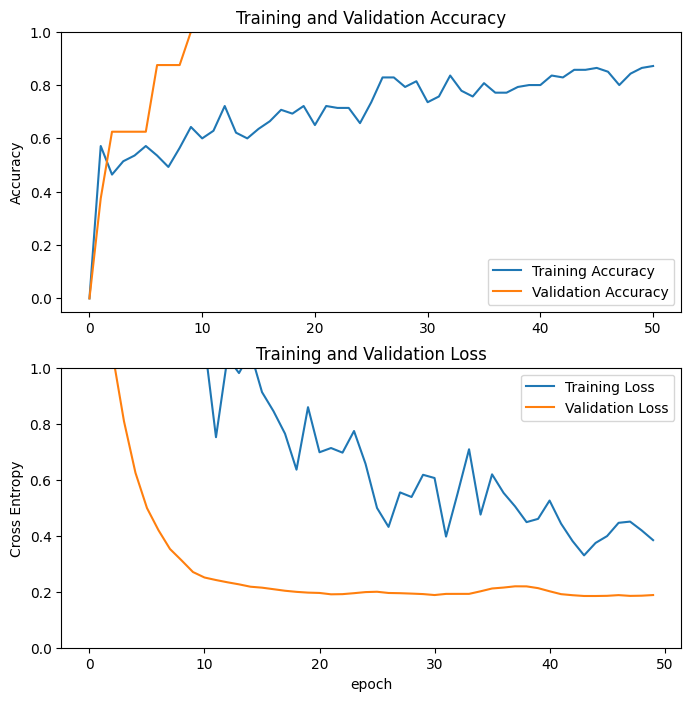

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:

def resnet_model_2(X, augmentation=data_augmenter()):
    '''
    classification model
    '''
    
#     input_shape = X[0].shape
    
    model_2 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)
    
    # Fine-tune from this layer onwards
    fine_tune_at = 165


    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model_2.layers[:fine_tune_at]:
        #print('Layer ' + layer.name + ' frozen.')
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=X[0].shape)
    
    x = augmentation(inputs)
    
    x = preprocess_data(x)
    
    x = model_2(x)
    
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.6)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1,activation="sigmoid")
    
    outputs = prediction_layer(x) 
    mod_2 = tf.keras.Model(inputs, outputs)
    
    return mod_2

In [16]:
resNet_2 = resnet_model_2(X_train, augmentation=data_augmenter())

In [17]:
resNet_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [18]:
resNet_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
initial_epochs = 50
history_2 = resNet_2.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50


C:\Users\User\pyver\py3107\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 5s 387ms/step - loss: 1.1017 - accuracy: 0.5357 - val_loss: 0.5310 - val_accuracy: 0.8750
Epoch 2/50
5/5 [==============================] - 1s 223ms/step - loss: 0.6822 - accuracy: 0.7071 - val_loss: 0.3066 - val_accuracy: 0.8750
Epoch 3/50
5/5 [==============================] - 1s 222ms/step - loss: 0.4093 - accuracy: 0.8571 - val_loss: 0.1887 - val_accuracy: 1.0000
Epoch 4/50
5/5 [==============================] - 1s 221ms/step - loss: 0.2944 - accuracy: 0.8643 - val_loss: 0.2102 - val_accuracy: 1.0000
Epoch 5/50
5/5 [==============================] - 1s 227ms/step - loss: 0.3617 - accuracy: 0.8357 - val_loss: 0.2848 - val_accuracy: 0.8750
Epoch 6/50
5/5 [==============================] - 1s 233ms/step - loss: 0.3264 - accuracy: 0.8643 - val_loss: 0.3283 - val_accuracy: 0.8750
Epoch 7/50
5/5 [==============================] - 1s 226ms/step - loss: 0.1381 - accuracy: 0.9429 - val_loss: 0.3403 - val_accuracy: 0.8750
Epoch 8/50
5/5 [===============

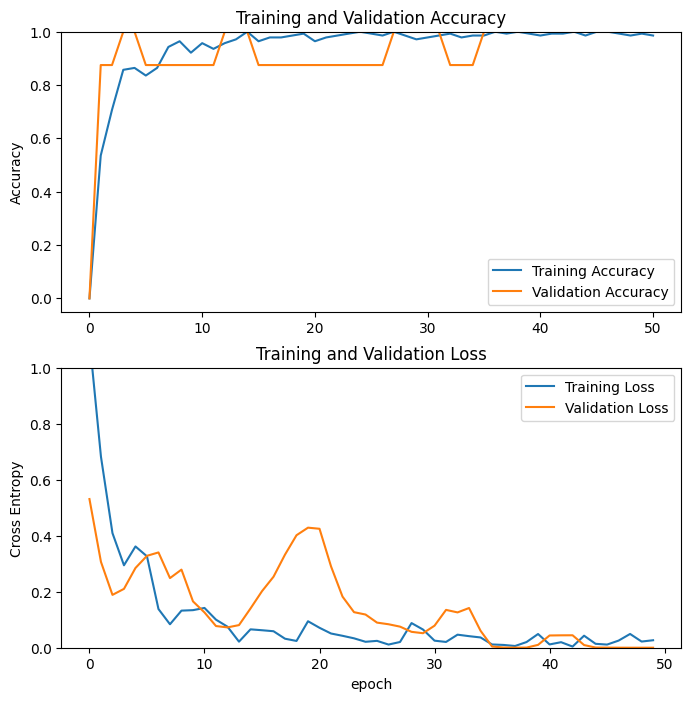

In [20]:
acc = [0.] + history_2.history['accuracy']
val_acc = [0.] + history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()